<a href="https://colab.research.google.com/github/jghcobussen/PRA3024/blob/master/Week5_MsPacman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Ms Packman

Creator: Joyce Cobussen

Student ID: i6170709

Information: Throughout the code, several comments starting with 'INFO' explain the workings and/or function of certain aspects of the code. I mainly did this for myself to improve my understanding of the code. This code was taken from the book 'Pyhon reinforcement learning' by Sudharsan Ravichandiran, Sean Saito, Rajalingappaa Shanmugamani and Yang Wenzhuo (2019). Slight adjustments were made. The main purpose of this code was to understand how different parameters influence the speed and effectiveness of the learning process. 

In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

In [0]:
color = np.array([210, 164, 74]).mean()


# Definition to prepare the original input game screen into a cropped, gray-scale version

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:176:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


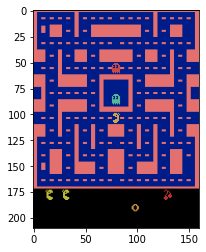

In [3]:
# Create the game environment and show the initial game screen, as well as the possible
# actions that can be taken

env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

# env.reset resets the environment and returns the initial observation
observation = env.reset()

import tensorflow as tf
import matplotlib.pyplot as plt

for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

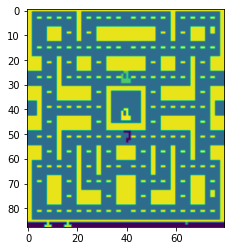

(210, 160, 3)
(88, 80)


In [4]:
# Printing the preprocessed game screen to check that it is a cropped and gray-scale image 
# compared to the original gamescreen.

# Printing the original and preprocessed tensors to check that it goes from 3D to 2D

obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

In [0]:
tf.compat.v1.reset_default_graph()

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 

      # INFO: stride regulates how many steps a convolutional layer moves. A larger stride reduces the computational
      # load in return for a certain loss of data. Since we want to start with recognizing general features and go
      # into more detail later, the stride size decreases with each convolutional layer.

      # INFO: kernal size dictates how big the filter is that moves over the image. I choose to start off with a 
      # relatively large filter to look for major patterns and end with a smaller one, which is more sensitive to 
      # smaller patterns. This way, I hope to increase the learning ability of the network while reducing computing
      # time and lower the chance of overtraining it. 

        # Add 3 convolutional layers 
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(2,2), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_3)
        
        # Insert a fully connected layer
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        
        #Add final output layer that has the same number of outputs as there are actions to take, 9 in our case
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        
        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        #Return both variables and outputs together
        return vars, output

In [0]:
# INFO: Define a function that selects the action with the highest reward with a probability of (1-epsilon), or a random action
# with probability epsilon. At the start we would like the AI to explore, so make epsilon large in the beginning. As time
# passes, we would like the AI to rely on what it has learned more and more, so we make epsilon decrease by a certain 
# amount each step. 

epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action


In [0]:
buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)

In [0]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

In [0]:
# The AI needs relatively many episodes to show some improvement. Due to time constraints
# I put 400, but it will probably need at least 1000 to converge and perhaps even more.
num_episodes = 400
batch_size = 48
input_shape = (None, 88, 80, 1)
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000


In [0]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

# Now we define the placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [11]:

# This builds the Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# Similarly, the line below builds the target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [0]:
# Define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)

In [0]:
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [0]:
# Define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [15]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])

                        # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))

Epochs per episode: 688 Episode Reward: 310.0 Episode number: 1
Epochs per episode: 547 Episode Reward: 170.0 Episode number: 2
Epochs per episode: 578 Episode Reward: 190.0 Episode number: 3
Epochs per episode: 584 Episode Reward: 200.0 Episode number: 4
Epochs per episode: 859 Episode Reward: 460.0 Episode number: 5
Epochs per episode: 549 Episode Reward: 100.0 Episode number: 6
Epochs per episode: 640 Episode Reward: 270.0 Episode number: 7
Epochs per episode: 547 Episode Reward: 130.0 Episode number: 8
Epochs per episode: 670 Episode Reward: 190.0 Episode number: 9
Epochs per episode: 616 Episode Reward: 180.0 Episode number: 10
Epochs per episode: 916 Episode Reward: 320.0 Episode number: 11
Epochs per episode: 544 Episode Reward: 140.0 Episode number: 12
Epochs per episode: 627 Episode Reward: 210.0 Episode number: 13
Epochs per episode: 753 Episode Reward: 200.0 Episode number: 14
Epochs per episode: 668 Episode Reward: 220.0 Episode number: 15
Epochs per episode: 645 Episode Re

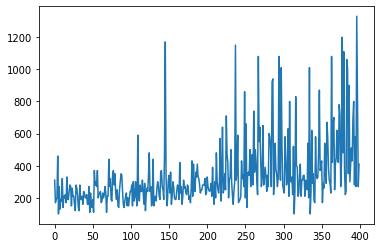

In [16]:
plt.plot(history)
plt.show()

The graph above shows a very noisy trend. However, it's mean result does seem to increase and the lower bound of the graph clearly increases over time. 